In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

from PIL import Image

In [117]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"

# Improving the model - Adding more data

As we saw in the experiments with the first model, the main problems with the current model is that there are not enough different situations that allow the model to consider confounding images, e.g. clouds, as non fire images. We also saw that changing the optimizer to a more complex one (Adam) and decreasing the size of the images of the FIRE Dataset made the previsions worse.

This establishes the main objective for the next models:

- Train models with more images

For this, we will use the dataset that comprises the images of the FIRE dataset and of the Forest Fire dataset. We will then try training with the two datasets and The Wildfire Dataset and see how the model improves.

Since compressing the size of the images of the FIRE dataset made previsions worse, we will start by adding the original images to the composed datasets.

In [3]:
# We will call the FIRE + Forest Fire dataset the 3 F's dataset to make naming easier
fire_forest_fire_dataset_path = os.path.join(base_path, "new_fire_forest_fire_datasets")

In [4]:
three_f_fire_path = os.path.join(fire_forest_fire_dataset_path, "fire_images")
os.makedirs(three_f_fire_path, exist_ok=True)

three_f_non_fire_path = os.path.join(fire_forest_fire_dataset_path, "non_fire_images")
os.makedirs(three_f_non_fire_path)

In [5]:
import shutil

In [7]:
fire_dataset_fire_path = os.path.join(base_path, "FIRE Dataset", "fire_images")
for filename in os.listdir(fire_dataset_fire_path):
    shutil.copy2(os.path.join(fire_dataset_fire_path, filename), three_f_fire_path)

fire_dataset_non_fire_path = os.path.join(base_path, "FIRE Dataset", "non_fire_images")
for filename in os.listdir(fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(fire_dataset_non_fire_path, filename), three_f_non_fire_path)

In [9]:
forest_fire_dataset_fire_path = os.path.join(base_path, "Forest Fire Dataset", "fire_images")
for filename in os.listdir(forest_fire_dataset_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_fire_path, filename), three_f_fire_path)

forest_fire_dataset_non_fire_path = os.path.join(base_path, "Forest Fire Dataset", "non_fire_images")
for filename in os.listdir(forest_fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_non_fire_path, filename), three_f_non_fire_path)

In [118]:
full_dataset_path = os.path.join(base_path, "new_full_dataset")

In [120]:
full_dataset_fire_path = os.path.join(full_dataset_path, "fire_images")
os.makedirs(full_dataset_fire_path, exist_ok=True)

full_dataset_non_fire_path = os.path.join(full_dataset_path, "non_fire_images")
os.makedirs(full_dataset_non_fire_path, exist_ok=True)

In [12]:
for filename in os.listdir(fire_dataset_fire_path):
    shutil.copy2(os.path.join(fire_dataset_fire_path, filename), full_dataset_fire_path)

for filename in os.listdir(fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(fire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

In [13]:
for filename in os.listdir(forest_fire_dataset_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_fire_path, filename), full_dataset_fire_path)

for filename in os.listdir(forest_fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

In [14]:
wildfire_dataset_fire_path = os.path.join(base_path, "wildfire_dataset", "fire_images")
for filename in os.listdir(wildfire_dataset_fire_path):
    shutil.copy2(os.path.join(wildfire_dataset_fire_path, filename), full_dataset_fire_path)

wildfire_dataset_non_fire_path = os.path.join(base_path, "wildfire_dataset", "non_fire_images")
for filename in os.listdir(wildfire_dataset_non_fire_path):
    shutil.copy2(os.path.join(wildfire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

Let's create the data analysis plot of this folder first before continuing.

In [43]:
df_full = pd.DataFrame(columns=['path', 'label', 'width', 'height'])

for dirname, _, filenames in os.walk(full_dataset_fire_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'fire', width, height]], columns=['path','label', 'width', 'height'])], axis=0)

for dirname, _, filenames in os.walk(full_dataset_non_fire_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'no fire', width, height]],columns=['path','label', 'width', 'height'])], axis=0)

df_full = df_full.sample(frac=1).reset_index(drop=True)
df_full.head(10)

,path,label,width,height
0,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360
1,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,640,480
2,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,300,168
3,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,267,189
4,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,853,480
5,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,640,480
6,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360
7,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360
8,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,721,480
9,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360


In [44]:
len(df_full.index)

6917

In [88]:
# Extracting data
labels = df_full['label'].value_counts().index
counts = df_full['label'].value_counts().to_numpy()

# Bar chart
bar_trace = go.Bar(
    x=labels,
    y=counts,
    marker_color=['darkorange', 'green'],
    text=[str(count) for count in counts],
    showlegend=False
)

fig_bar = go.Figure(data=[bar_trace])
fig_bar.update_layout(title='Bar Chart', 
                      width=1000, 
                      height=700, 
                      xaxis=dict(tickfont=dict(size=16)),  # Adjust the size as needed
                      yaxis=dict(tickfont=dict(size=16), dtick=700),
                      font=dict(size=16)
                     )
fig_bar.show()

In [230]:
# Pie chart
pie_trace = go.Pie(
    values=counts,
    labels=labels,
    marker=dict(colors=['green', 'darkorange']),
)

fig_pie = go.Figure(data=[pie_trace])
fig_pie.update_layout(width=1000, height=700, font=dict(size=32))
fig_pie.show()

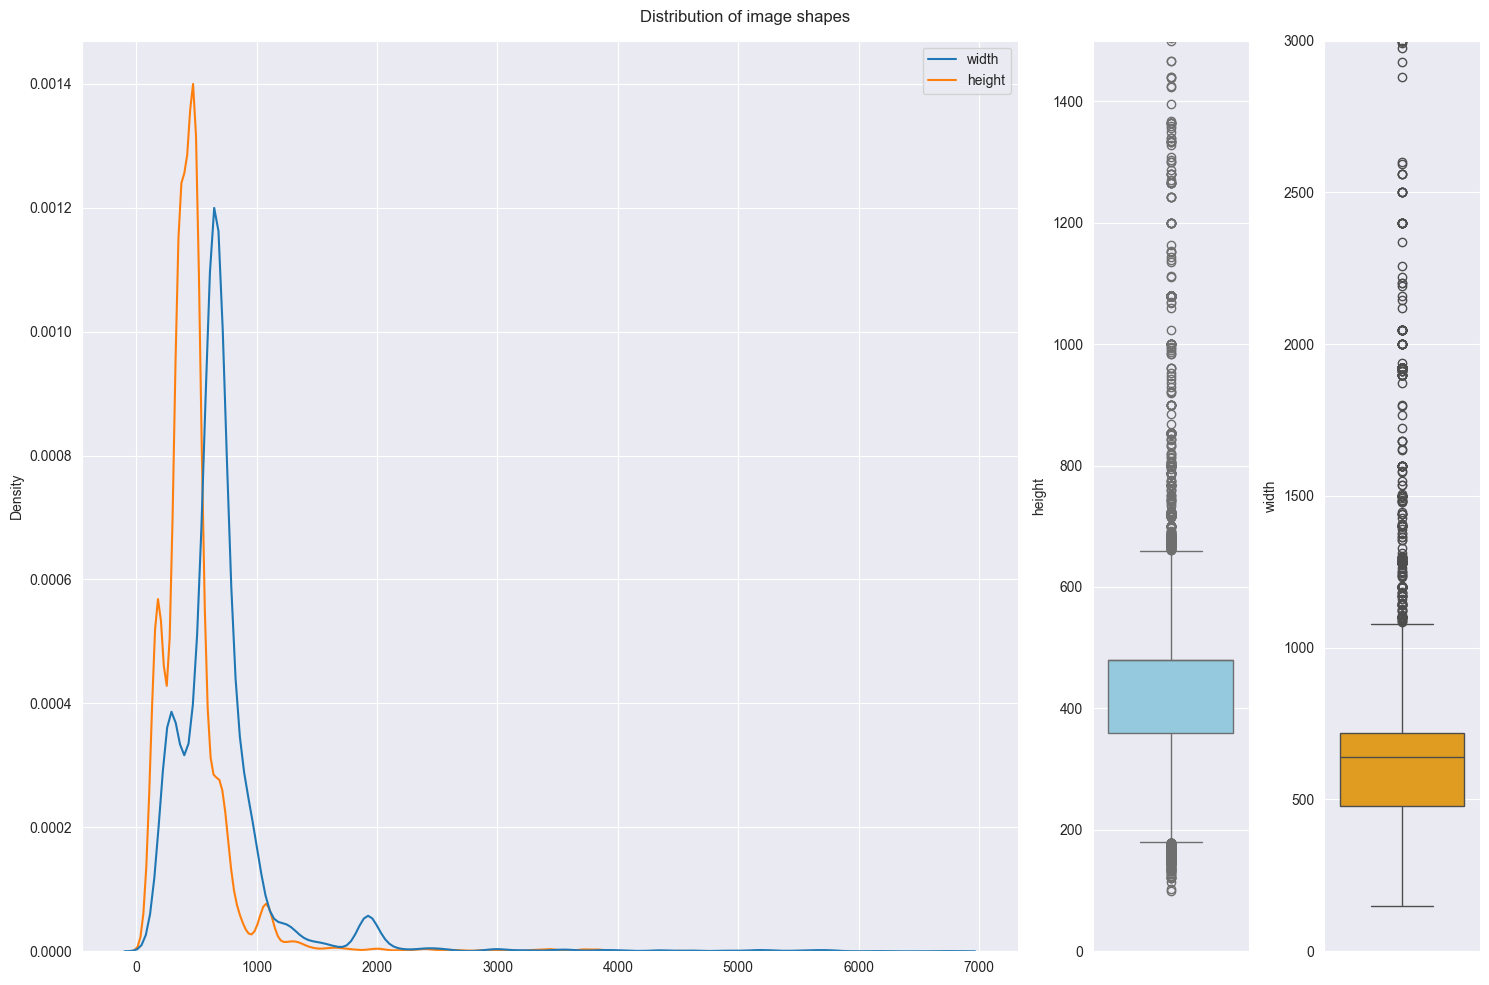

In [96]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df_full.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df_full,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df_full,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,3000)
ax2.set_ylim(0,1500)
plt.tight_layout()

In [47]:
df_full_ratio = df_full.copy()
df_full_ratio['ratio'] = np.where(df_full['width'] > df_full['height'], df_full['width'] / df_full['height'], df_full['height'] / df_full['width'])
df_full_ratio

,path,label,width,height,ratio
0,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360,1.777778
1,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,640,480,1.333333
2,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,300,168,1.785714
3,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,267,189,1.412698
4,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,853,480,1.777083
...,...,...,...,...,...
6912,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,720,480,1.5
6913,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,fire,960,540,1.777778
6914,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360,1.777778
6915,C:\Users\johnn\Desktop\Repos\Capstonfire\new_f...,no fire,640,360,1.777778


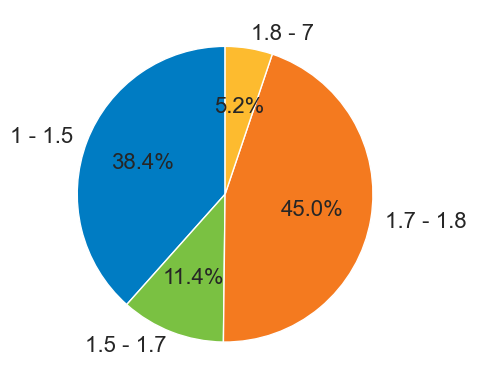

In [110]:
bin_edges = [0.99, 1.5, 1.7, 1.8, 7]
labels = ['1 - 1.5', '1.5 - 1.7', '1.7 - 1.8', '1.8 - 7']
bins = pd.cut(df_full_ratio['ratio'], bins=bin_edges, labels=labels)
# Plot a pie chart
colors = ['#007CC3', '#7AC142', '#F47A1F', '#FDBB2F', '#377B2B']
bins.value_counts(sort=False).plot.pie(autopct='%1.1f%%', startangle=90, colors=colors, fontsize=16)
plt.ylabel('')
plt.show()

Done. The Wildfire Dataset is still compressed to save size and avoid having the model take too long to analyse large images.

Let's start training.

In [121]:
import os
from capstonfire_utils import plot_loss, plot_accuracy, FireDataset, split_dataset_into_dataloaders, train_model, calculate_metrics, run_video

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchsummary

from torchviz import make_dot

base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
fire_forest_fire_dataset_path = os.path.join(base_path, "new_fire_forest_fire_datasets")

In [122]:
three_f_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [123]:
three_f_dataset = FireDataset(fire_forest_fire_dataset_path, three_f_transform)

In [124]:
three_f_train_loader, three_f_val_loader, three_f_test_loader = split_dataset_into_dataloaders(three_f_dataset, 50, 0.7, 0.2, 0.1)

In [125]:
len(three_f_train_loader.dataset) + len(three_f_val_loader.dataset) + len(three_f_test_loader.dataset)

4218

In [126]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50)
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

three_f_model = SimpleCNN()

In [127]:
torchsummary.summary(model=three_f_model, input_size=(3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 252, 252]             760
            Conv2d-2         [-1, 20, 122, 122]           5,020
            Linear-3                   [-1, 50]       3,721,050
            Linear-4                    [-1, 2]             102
Total params: 3,726,932
Trainable params: 3,726,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.12
Params size (MB): 14.22
Estimated Total Size (MB): 22.08
----------------------------------------------------------------


In [128]:
three_f_model_name = "dummy_cnn_two_datasets"

In [129]:
x = torch.randn(50, 3, 256, 256)  # A dummy input tensor to pass through the model
y = three_f_model(x)

dot = make_dot(y, params=dict(list(three_f_model.named_parameters()) + [('x', x)]))
dot.render('model details/' + three_f_model_name + '-model_visualization', format='png')

'model details\\dummy_cnn_two_datasets-model_visualization.png'

In [130]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model.parameters(), lr=0.0003, momentum=0.9)

In [131]:
three_f_history = train_model(three_f_model, criterion, optimizer, base_path, three_f_model_name, 20, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


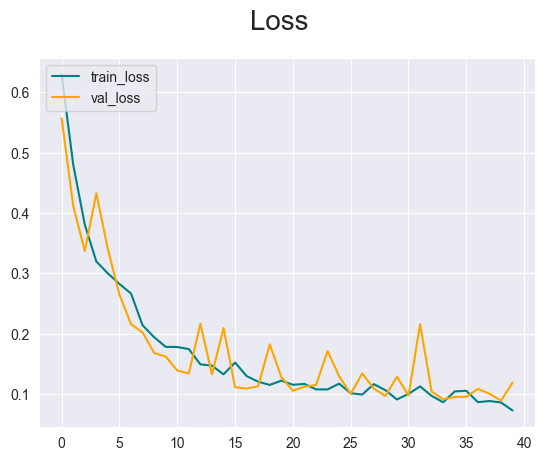

In [132]:
plot_loss(three_f_history["avg_train_loss_list"], three_f_history["avg_val_loss_list"])

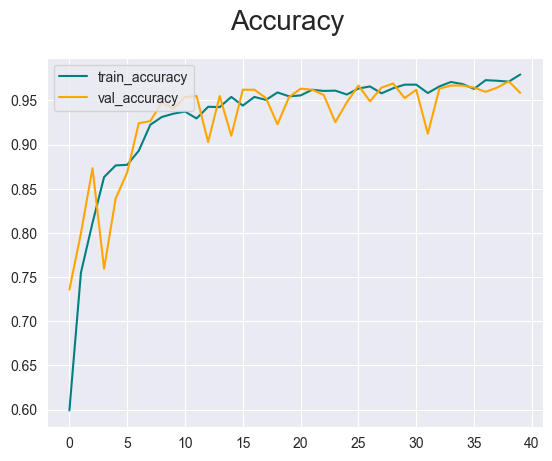

In [133]:
plot_accuracy(three_f_history["train_accuracy_list"], three_f_history["val_accuracy_list"])

In [134]:
custom_test_loader = DataLoader(FireDataset(os.path.join(base_path, "test dataset"), three_f_transform), 50, False)

calculate_metrics(three_f_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 

Let's compare with the first model:

In [40]:
model_name = "dummy_cnn"
first_model = SimpleCNN()
first_history = train_model(first_model, criterion, optimizer, base_path, model_name, 20, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


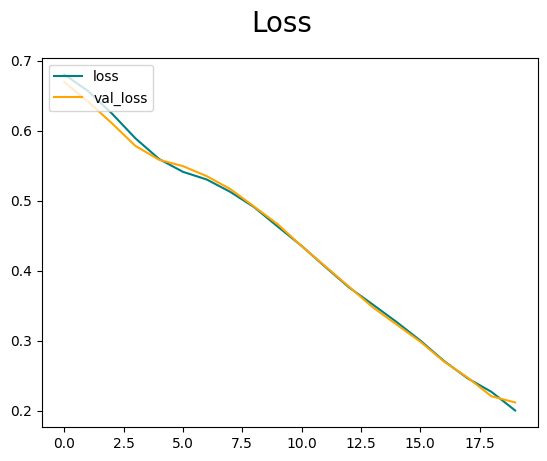

In [44]:
plot_loss(first_history["avg_train_loss_list"], first_history["avg_val_loss_list"])

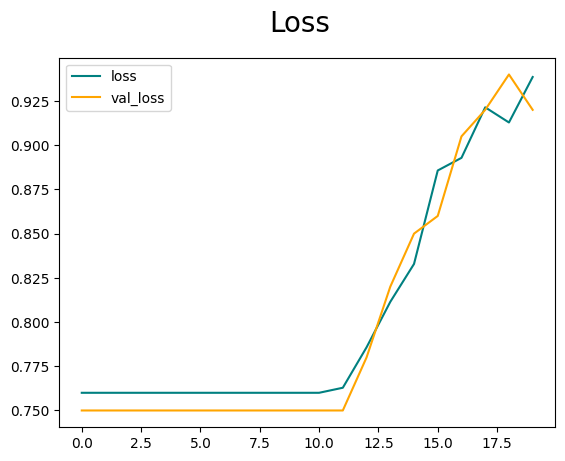

In [45]:
plot_accuracy(first_history["train_accuracy_list"], first_history["val_accuracy_list"])

In [43]:
calculate_metrics(first_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.75
Precision on the test set: 0.75
F1 Score on the test set: 0.75


Looks like it got worse. The loss is lower and the training/validation accuracy is better, which means that the model probaby overfitted. Let's train again but before the loss starts to stagnate, which was at about 12 epochs.

In [57]:
three_f_model_name = "dummy_cnn_two_datasets_12"
three_f_model_12 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model_12.parameters(), lr=0.0003, momentum=0.9)

three_f_12_history = train_model(three_f_model_12, criterion, optimizer, base_path, three_f_model_name, 12, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


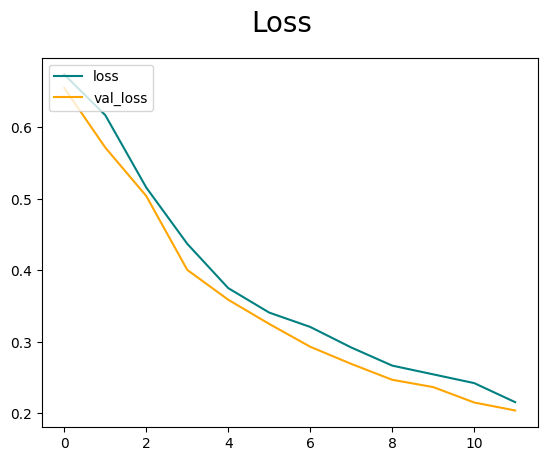

In [58]:
plot_loss(three_f_12_history["avg_train_loss_list"], three_f_12_history["avg_val_loss_list"])

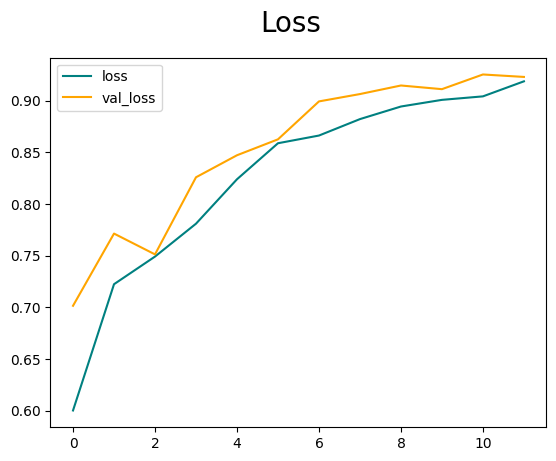

In [59]:
plot_accuracy(three_f_12_history["train_accuracy_list"], three_f_12_history["val_accuracy_list"])

In [60]:
calculate_metrics(three_f_model_12, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.47
Precision on the test set: 0.47
F1 Score on the test set: 0.47


Hmm wow, so the dataset did not overfit. But training more than 20 epochs seems like it would not make much of a difference. What if we train the first model with only the FIRE Dataset with more epochs, what would be the metrics then?

In [62]:
fire_dataset = FireDataset(os.path.join(base_path, "FIRE Dataset"), transforms=transforms.Compose([
                                                                        transforms.Resize((256, 256)),
                                                                        transforms.ToTensor()
                                                                    ])
)

fire_train_loader, fire_val_loader, fire_test_loader = split_dataset_into_dataloaders(fire_dataset, 50, 0.7, 0.2, 0.1)

model_name = "dummy_cnn_30"
first_model_30 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(first_model_30.parameters(), lr=0.0003, momentum=0.9)

first_history_30 = train_model(first_model_30, criterion, optimizer, base_path, model_name, 30, fire_train_loader, fire_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 0.7280, Train Accuracy: 0.2414, Validation Loss: 0.6977, Validation Accuracy: 0.4000
Epoch [2/30], Train Loss: 0.6640, Train Accuracy: 0.6771, Validation Loss: 0.6173, Validation Accuracy: 0.7700
Epoch [3/30], Train Loss: 0.5976, Train Accuracy: 0.7586, Validation Loss: 0.5568, Validation Accuracy: 0.7700
Epoch [4/30], Train Loss: 0.5617, Train Accuracy: 0.7586, Validation Loss: 0.5406, Validation Accuracy: 0.7700
Epoch [5/30], Train Loss: 0.5467, Train Accuracy: 0.7586, Validation Loss: 0.5236, Validation Accuracy: 0.7700
Epoch [6/30], Train Loss: 0.5277, Train Accuracy: 0.7586, Validation Loss: 0.5049, Validation Accuracy: 0.7700
Epoch [7/30], Train Loss: 0.5040, Train Accuracy: 0.7586, Validation Loss: 0.4826, Validation Accuracy: 0.7700
Epoch [8/30], Train Loss: 0.4779, Train Accuracy: 0.7586, Validation Loss: 0.4569, Validation Accuracy: 0.7700
Epoch [9/30], Train Loss: 0.4466, Train Accuracy: 0.7586, Validation Loss: 0.4265, Validation Accuracy: 0.7700
E

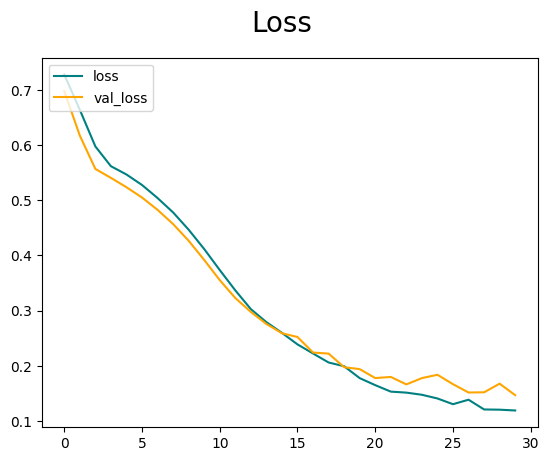

In [64]:
plot_loss(first_history_30["avg_train_loss_list"], first_history_30["avg_val_loss_list"])

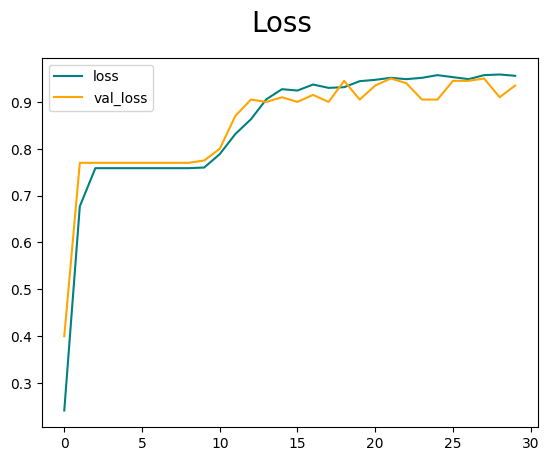

In [65]:
plot_accuracy(first_history_30["train_accuracy_list"], first_history_30["val_accuracy_list"])

In [63]:
calculate_metrics(first_model_30, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.70
Precision on the test set: 0.70
F1 Score on the test set: 0.70


Ah, it got worse, which means it overfitted. 20 epochs was conveniently the last epoch before validation loss increased for the first time, which seemed to be the best number of epochs for the FIRE Dataset. For the FIRE + Forest Fire dataset, that value seems to be 6 epochs. Let's train with this dataset with 6 epochs and see how it turns out.

In [67]:
three_f_model_name = "dummy_cnn_two_datasets_6"
three_f_model_6 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model_6.parameters(), lr=0.0003, momentum=0.9)

three_f_6_history = train_model(three_f_model_6, criterion, optimizer, base_path, three_f_model_name, 6, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/6], Train Loss: 0.6528, Train Accuracy: 0.6627, Validation Loss: 0.5818, Validation Accuracy: 0.7464
Epoch [2/6], Train Loss: 0.4946, Train Accuracy: 0.7589, Validation Loss: 0.4564, Validation Accuracy: 0.7915
Epoch [3/6], Train Loss: 0.4069, Train Accuracy: 0.7944, Validation Loss: 0.3691, Validation Accuracy: 0.8329
Epoch [4/6], Train Loss: 0.3529, Train Accuracy: 0.8405, Validation Loss: 0.3237, Validation Accuracy: 0.8744
Epoch [5/6], Train Loss: 0.3127, Train Accuracy: 0.8774, Validation Loss: 0.2974, Validation Accuracy: 0.8732
Epoch [6/6], Train Loss: 0.2789, Train Accuracy: 0.8950, Validation Loss: 0.4090, Validation Accuracy: 0.7855
Finished Training


In [68]:
calculate_metrics(three_f_model_6, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.43
Precision on the test set: 0.43
F1 Score on the test set: 0.43


Nope, looks like there is no real pattern. With some epochs it is better, with worse it is other. For the same number of epochs, for some datasets the model overfits while for other datasets it is fine. So far, 20 epochs has been the best value for the combined FIRE and Forest Fire Datasets, even though loss is much lower than for the FIRE Dataset. The loss does decrease much faster than with only the FIRE Dataset, probably because there are more similar images of fires, which allows the model to converge faster.

Might make sense to store models after some number of epochs, for example, every 5 epochs or every 2 epochs, to compare which number is the best. Let's do some changes to the training cycle function.

In [6]:
import json
from tqdm import tqdm
from tqdm.notebook import tqdm
from capstonfire_utils import plot_loss, plot_accuracy, FireDataset, split_dataset_into_dataloaders, calculate_metrics, run_video

In [140]:
def train_model(model: torch.nn.Module,criterion, optimizer, 
                models_folder_path: str, model_filename: str, 
                num_epochs: int, 
                train_loader: DataLoader, val_loader: DataLoader, 
                epoch_checkpoints: int = 0):
    

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    if epoch_checkpoints < 1:
        print("Checkpoints smaller than 1. Only the final model will be saved.")

    model = model.to(device)
    criterion = criterion.to(device)

    history = {
        "avg_train_loss_list": [],
        "train_accuracy_list": [],
        "avg_val_loss_list": [],
        "val_accuracy_list": []
    }

    start_range = 0

    hist_file_path = os.path.join(models_folder_path, model_filename + '.json')
    
    # Retrieve model if it was already trained. The state loaded will be that of the last epoch.
    if model_filename + '.pt' in os.listdir(models_folder_path):
        model.load_state_dict(torch.load(os.path.join(models_folder_path, model_filename +'.pt')))
        
        with open(hist_file_path, 'r') as json_file:
            history = json.load(json_file)

        # If num_epochs is equal or lower to the epochs of a previously trained model, skip training. Else continue training
        if len(history["avg_train_loss_list"]) >= num_epochs:
            return history
        else:
            start_range = len(history["avg_train_loss_list"])

    # if model was never trained, enter loop. If asking for more epochs, start from where model was left off
    for epoch in tqdm(list(range(start_range, num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Do not save if there is no indication to store intermediate models or if it is the last iteration of the training loop
        if epoch_checkpoints < 1:
            continue

        # Store models after every epoch_checkpoints number of epochs
        if (epoch + 1) % epoch_checkpoints == 0 and epoch > 0:
            path_to_model_folder = os.path.join(models_folder_path, model_filename)

            if not os.path.exists(path_to_model_folder):
                os.makedirs(path_to_model_folder, exist_ok=True)
                
            torch.save(model.state_dict(), os.path.join(path_to_model_folder, "epoch_" + str(epoch + 1) + '.pt'))

    print('Finished Training')

    # save model at last epoch
    torch.save(model.state_dict(), os.path.join(models_folder_path, model_filename + '.pt'))

    # Write history dictionary to a JSON file
    with open(hist_file_path, 'w+') as json_file:
        json.dump(history, json_file)

    return history

Let's test this.

In [133]:
three_f_model_name = "dummy_cnn_two_datasets"
three_f_model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model.parameters(), lr=0.0003, momentum=0.9)

three_f_history = train_model(three_f_model, criterion, optimizer, os.path.join(base_path, "trained_models"), three_f_model_name, 20, three_f_train_loader, three_f_val_loader, 2)

CUDA is available. Using GPU.


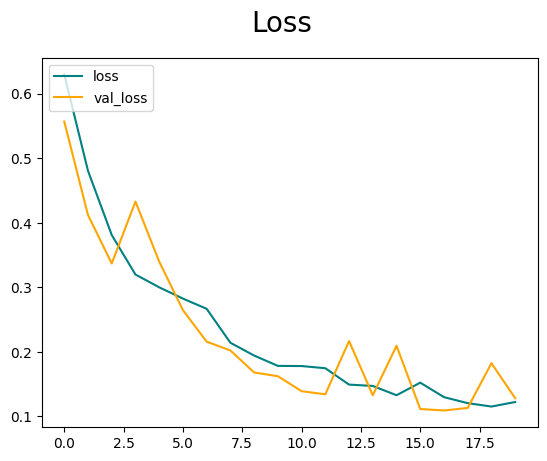

In [134]:
plot_loss(three_f_history["avg_train_loss_list"], three_f_history["avg_val_loss_list"])

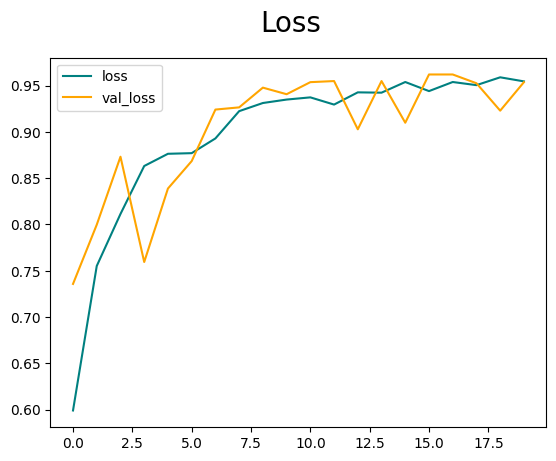

In [135]:
plot_accuracy(three_f_history["train_accuracy_list"], three_f_history["val_accuracy_list"])

In [8]:
from torchmetrics.classification import Precision, Recall, F1Score

In [131]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

intermediate_model = SimpleCNN().to(device)

epoch_metrics = {}

for dirpath, _, filenames in os.walk(os.path.join(base_path, "trained_models", three_f_model_name)):
    for model_filename in tqdm(filenames):
        intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))
        print(model_filename + " metrics:")

        recall = Recall(task='multiclass',num_classes=2).to(device)
        precision = Precision(task='multiclass',num_classes=2).to(device)
        f1 = F1Score(task='multiclass',num_classes=2).to(device)

        with torch.no_grad():
            for data in custom_test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = intermediate_model(inputs)  # forward
                #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                predictions = torch.argmax(outputs, dim=1)

                recall.update(predictions, labels)
                precision.update(predictions, labels)
                f1.update(predictions, labels)

        precision_value = precision.compute()
        recall_value = recall.compute()
        f1_value = f1.compute()

        print('Precision/Recall/F1 Score')
        print('  %.2f     %.2f   %.2f'% (precision_value, recall_value, f1_value))

        epoch_metrics[model_filename] = {
            "Precision": precision_value, 
            "Recall": recall_value, 
            "F1Score": f1_value
            }

CUDA is available. Using GPU.


  0%|          | 0/9 [00:00<?, ?it/s]

epoch_10.pt metrics:


KeyboardInterrupt: 

In [116]:
calculate_metrics(three_f_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.53
Precision on the test set: 0.53
F1 Score on the test set: 0.53


Looks like the ideal number of epochs is not 6, 12 or 20, but somewhere between 16 and 18. Still, the metrics are worse than with just the FIRE Dataset.

Let's try 40 epochs and see how that turns out.

In [155]:
three_f_history = train_model(three_f_model, criterion, optimizer, os.path.join(base_path, "trained_models"), three_f_model_name, 40, three_f_train_loader, three_f_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/40], Train Loss: 0.1154, Train Accuracy: 0.9556, Validation Loss: 0.1054, Validation Accuracy: 0.9633
Epoch [22/40], Train Loss: 0.1169, Train Accuracy: 0.9621, Validation Loss: 0.1124, Validation Accuracy: 0.9621
Epoch [23/40], Train Loss: 0.1079, Train Accuracy: 0.9607, Validation Loss: 0.1151, Validation Accuracy: 0.9562
Epoch [24/40], Train Loss: 0.1077, Train Accuracy: 0.9611, Validation Loss: 0.1714, Validation Accuracy: 0.9254
Epoch [25/40], Train Loss: 0.1173, Train Accuracy: 0.9567, Validation Loss: 0.1295, Validation Accuracy: 0.9479
Epoch [26/40], Train Loss: 0.1014, Train Accuracy: 0.9634, Validation Loss: 0.1004, Validation Accuracy: 0.9668
Epoch [27/40], Train Loss: 0.0993, Train Accuracy: 0.9658, Validation Loss: 0.1342, Validation Accuracy: 0.9491
Epoch [28/40], Train Loss: 0.1165, Train Accuracy: 0.9580, Validation Loss: 0.1093, Validation Accuracy: 0.9645
Epoch [29/40], Train Loss: 0.1066, Train Accuracy: 0.9638, Validation Loss: 0.0968, Validation Accuracy:

In [156]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

intermediate_model = SimpleCNN().to(device)

epoch_metrics = {}

for dirpath, _, filenames in os.walk(os.path.join(base_path, "trained_models", three_f_model_name)):
    for model_filename in tqdm(filenames):
        intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))
        print(model_filename + " metrics:")

        recall = Recall(task='multiclass',num_classes=2).to(device)
        precision = Precision(task='multiclass',num_classes=2).to(device)
        f1 = F1Score(task='multiclass',num_classes=2).to(device)

        with torch.no_grad():
            for data in custom_test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = intermediate_model(inputs)  # forward
                #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                predictions = torch.argmax(outputs, dim=1)

                recall.update(predictions, labels)
                precision.update(predictions, labels)
                f1.update(predictions, labels)

        precision_value = precision.compute()
        recall_value = recall.compute()
        f1_value = f1.compute()

        print('Precision/Recall/F1 Score')
        print('  %.2f     %.2f   %.2f'% (precision_value, recall_value, f1_value))

        epoch_metrics[model_filename] = {
            "Precision": precision_value, 
            "Recall": recall_value, 
            "F1Score": f1_value
            }

CUDA is available. Using GPU.


  0%|          | 0/19 [00:00<?, ?it/s]

epoch_10.pt metrics:
Precision/Recall/F1 Score
  0.51     0.51   0.51
epoch_12.pt metrics:
Precision/Recall/F1 Score
  0.56     0.56   0.56
epoch_14.pt metrics:
Precision/Recall/F1 Score
  0.52     0.52   0.52
epoch_16.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_18.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_2.pt metrics:
Precision/Recall/F1 Score
  0.35     0.35   0.35
epoch_22.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_24.pt metrics:
Precision/Recall/F1 Score
  0.54     0.54   0.54
epoch_26.pt metrics:
Precision/Recall/F1 Score
  0.57     0.57   0.57
epoch_28.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_30.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_32.pt metrics:
Precision/Recall/F1 Score
  0.53     0.53   0.53
epoch_34.pt metrics:
Precision/Recall/F1 Score
  0.60     0.60   0.60
epoch_36.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_38.pt metrics:


In [9]:
import pandas as pd

In [10]:
def sort_metrics(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df = df.map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    df = df.rename(index=lambda x: int(x.split('_')[1].split('.')[0]))
    return df.sort_index()

In [157]:
sort_metrics(epoch_metrics)

,Precision,Recall,F1Score
2,0.345461,0.345461,0.345461
4,0.420227,0.420227,0.420227
6,0.462283,0.462283,0.462283
8,0.477303,0.477303,0.477303
10,0.510013,0.510013,0.510013
12,0.557076,0.557076,0.557076
14,0.522363,0.522363,0.522363
16,0.586115,0.586115,0.586115
18,0.594459,0.594459,0.594459
22,0.551402,0.551402,0.551402


The max seems to be at 38 epochs, however it is just an improvement of 3% over epoch 18. Not to mention it is still a lot worse than the model with just the FIRE Dataset. Not worth using it for anything.

Let's now add the third dataset and see how things turn out.

In [11]:
full_dataset_path = os.path.join(base_path, "new_full_dataset")

In [33]:
full_dataset = FireDataset(full_dataset_path, transforms=transforms.Compose([
                                                                        transforms.Resize((256, 256)),
                                                                        transforms.ToTensor()
                                                                    ])
)

full_train_loader, full_val_loader, full_test_loader = split_dataset_into_dataloaders(full_dataset, 50, 0.7, 0.2, 0.1)

In [22]:
full_model_name = "dummy_cnn_full_dataset"
full_model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(full_model.parameters(), lr=0.0003, momentum=0.9)

three_f_history = train_model(full_model, criterion, optimizer, os.path.join(base_path, "trained_models"), full_model_name, 40, full_train_loader, full_val_loader, 2)

CUDA is available. Using GPU.


In [23]:
def calculate_epoch_metrics(models_path, model_name, test_loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    intermediate_model = SimpleCNN().to(device)

    epoch_metrics = {}

    for dirpath, _, filenames in os.walk(os.path.join(models_path, model_name)):
        for model_filename in tqdm(filenames):
            intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))

            recall = Recall(task='multiclass',num_classes=2).to(device)
            precision = Precision(task='multiclass',num_classes=2).to(device)
            f1 = F1Score(task='multiclass',num_classes=2).to(device)

            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = intermediate_model(inputs)  # forward
                    #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                    predictions = torch.argmax(outputs, dim=1)

                    recall.update(predictions, labels)
                    precision.update(predictions, labels)
                    f1.update(predictions, labels)

            precision_value = precision.compute()
            recall_value = recall.compute()
            f1_value = f1.compute()

            epoch_metrics[model_filename] = {
                "Precision": precision_value, 
                "Recall": recall_value, 
                "F1Score": f1_value
                }
    
    return epoch_metrics

In [115]:
full_epoch_metrics = calculate_epoch_metrics(os.path.join(base_path, "trained_models"), full_model_name, custom_test_loader)
sort_metrics(full_epoch_metrics)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

UnidentifiedImageError: cannot identify image file 'C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\test dataset\\non_fire_images\\1010out347.png'

In [167]:
full_epoch_metrics_sorted = sort_metrics(full_epoch_metrics)
full_epoch_metrics_sorted.loc[full_epoch_metrics_sorted['Precision'].idxmax()]

Precision    0.803071
Recall       0.803071
F1Score      0.803071
Name: 24, dtype: float64

Looks like at 24 epochs the model got 5% better than our model that was only trained with the first dataset.

Let's store this model and test it on the videos.

In [24]:
full_model_best = SimpleCNN()
full_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_name, "epoch_24.pt")))

<All keys matched successfully>

In [15]:
import random
from collections import Counter

In [17]:
videos_folder = os.path.join(base_path, "test dataset videos")

In [173]:
transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])

In [223]:
random_number = random.randint(0, 19)
random_odd_number = random_number + 1 if random_number % 2 == 0 else random_number
example_video = os.path.join(videos_folder, os.listdir(videos_folder)[random_odd_number])
example_video

'C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\test dataset videos\\storm_timelapse.mp4'

In [224]:
predictions = run_video(example_video, full_model_best, transform_video)
predictions

{'fire': 0.37625289128758677, 'non_fire': 0.6229760986892829}

In [28]:
def test_videos(videos_folder, model, transform):
    video_predictions = pd.DataFrame(columns=['video_name', '%_actual_fire_images', '%_actual_non_fire_images', '%_predicted_fire_images', '%_predicted_non_fire_images', '%_correct'])
    model = model.to('cpu')

    for folder in tqdm(os.listdir(videos_folder)):
        if "." in folder:
            continue

        folder_dataset = FireDataset(os.path.join(videos_folder, folder), transforms=transform)

        video_labels = {0: 0, 1: 0}
        for class_name, count in Counter([label for _, label in folder_dataset.data]).items():
            video_labels[class_name] = count 

        total_video_images = video_labels[0] + video_labels[1]

        fire_count = 0
        non_fire_count = 0
        is_correct = 0

        with torch.no_grad():
            for data in folder_dataset:
                input, label = data
                outputs = model(input)  # forward
                #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                current_prediction = torch.argmax(outputs, dim=1)

                # Count occurrences of 0 and 1 in predictions
                fire_count += torch.sum(current_prediction == 0).item()
                non_fire_count += torch.sum(current_prediction == 1).item()
                is_correct += torch.sum(current_prediction == label).item()
        
        video_predictions = pd.concat([video_predictions, 
                                            pd.DataFrame([[folder, video_labels[0]/total_video_images, video_labels[1]/total_video_images, fire_count/total_video_images, non_fire_count/total_video_images, is_correct/total_video_images]], 
                                            columns=['video_name', '%_actual_fire_images', '%_actual_non_fire_images', '%_predicted_fire_images', '%_predicted_non_fire_images', '%_correct'])])

    return video_predictions


video_predictions = test_videos(videos_folder, full_model_best, three_f_transform) 
video_predictions

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_17664\2593696194.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  video_predictions = pd.concat([video_predictions,


,video_name,%_actual_fire_images,%_actual_non_fire_images,%_predicted_fire_images,%_predicted_non_fire_images,%_correct
0,cloud_forming,0.000000,1.000000,0.309179,0.690821,0.690821
0,drone_footage,0.940850,0.059150,0.781885,0.218115,0.774492
0,firefighting,1.000000,0.000000,0.861878,0.138122,0.861878
0,forest_timelapse_2,0.000000,1.000000,0.107930,0.892070,0.892070
0,forest_time_lapse_1,0.000000,1.000000,0.000000,1.000000,1.000000
0,forest_video,0.000000,1.000000,0.095541,0.904459,0.904459
0,stock_footage,1.000000,0.000000,1.000000,0.000000,1.000000
0,storm_timelapse,0.000000,1.000000,0.643777,0.356223,0.356223
0,timelapse,0.674419,0.325581,0.502907,0.497093,0.677326
0,voa_fire,1.000000,0.000000,0.918182,0.081818,0.918182


In [29]:
video_predictions['%_correct'].mean()

0.8075451049998007

Results for all videos:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US" - actual: {'fire': 1, 'non_fire': 0}; predicted:{'fire': 0.86, 'non_fire': 0.14}
 - "Bighorn Fire Timelapse 6-17-2020" - actual: {'fire': 0.67, 'non_fire': 0.33}; predicted:{'fire': 0.5, 'non_fire': 0.5}
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a." - actual: {fire: 0.94, non_fire: 0.06}; predicted: {'fire': 0.78, 'non_fire': 0.22}
 - "Wildfire Forest Fire (FREE STOCK VIDEO)" - actual: {'fire': 1.0, 'non_fire': 0.0}; predicted: {'fire': 1.0, 'non_fire': 0.0}
 - "Aerial Footage Shows Scale of Fires in Australia" - actual: {'fire': 1, 'non_fire': 0}; predicted: {'fire': 0.92, 'non_fire': 0.08}

Non-fire videos:

 - "Amazing Storm Timelapse" - actual: {fire: 0, non_fire: 1.0}; predicted: {'fire': 0.64, 'non_fire': 0.36}
 - "NEMUS - 4K Forest Time-Lapse" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0, 'non_fire': 1}
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K" - actual: {fire: 0, non_fire: 1.0} ; predicted:{'fire': 0.11, 'non_fire': 0.89}
 - "Forming cumulonimbus (timelapse)" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.31, 'non_fire': 0.69}
 - "DARK FOG | Cinematic Video" - actual: {'fire': 0, 'non_fire': 1}; predicted: {'fire': 0.10, 'non_fire': 0.90}

Looks like for some videos the model predicted better, while for others the model predict less well. In general, the model seems to be predicting better, thanks to images from the Wildfire dataset. The images that might be making the most difference are those with smoke confounding elements, which seem like smoke but actually are not, which gives the model a better generalization capacity.

Right now there is not much time to improve the model, however things we can still do are:

- give more weight to non_fire images,
- find more images that are different to the ones we have now, and
- try a model with more filters, different kernel sizes and more layers.

For the second possibility, we chose not to do it because it would take a considerable longer time.

For the third possibility, we think that that would not work that well, due to previous experiments we had tried (see capstone_deeper_cnn.ipynb file which has one more Linear layer, more filters and smaller kernels).

Therefore, we decided to try and give more weights to non_fire images.

Let's do it.

In [39]:
full_model_weighted_name = "dummy_cnn_full_dataset_weighted"

class_weights = torch.tensor([1.0, 2.0])  # Weight 1 for fire images, weight 2 for non_fire images

full_model_weighted = SimpleCNN()

weighted_criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(full_model_weighted.parameters(), lr=0.0003, momentum=0.9)

full_model_weighted_history = train_model(full_model_weighted, weighted_criterion, optimizer, os.path.join(base_path, "trained_models"), full_model_weighted_name, 40, full_train_loader, full_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], Train Loss: 0.6146, Train Accuracy: 0.5423, Validation Loss: 0.5569, Validation Accuracy: 0.6221
Epoch [2/40], Train Loss: 0.5269, Train Accuracy: 0.6702, Validation Loss: 0.5212, Validation Accuracy: 0.6561
Epoch [3/40], Train Loss: 0.5021, Train Accuracy: 0.6853, Validation Loss: 0.5048, Validation Accuracy: 0.6908
Epoch [4/40], Train Loss: 0.4800, Train Accuracy: 0.6983, Validation Loss: 0.4974, Validation Accuracy: 0.7204
Epoch [5/40], Train Loss: 0.4757, Train Accuracy: 0.7016, Validation Loss: 0.4717, Validation Accuracy: 0.7009
Epoch [6/40], Train Loss: 0.4490, Train Accuracy: 0.7138, Validation Loss: 0.4558, Validation Accuracy: 0.7009
Epoch [7/40], Train Loss: 0.4376, Train Accuracy: 0.7266, Validation Loss: 0.4643, Validation Accuracy: 0.6705
Epoch [8/40], Train Loss: 0.4220, Train Accuracy: 0.7354, Validation Loss: 0.4292, Validation Accuracy: 0.7132
Epoch [9/40], Train Loss: 0.4090, Train Accuracy: 0.7472, Validation Loss: 0.4318, Validation Accuracy: 0.6922
E

In [136]:
custom_test_loader = DataLoader(FireDataset(os.path.join(base_path, "test dataset"), three_f_transform), 50, False)

In [137]:
full_weigthed_epoch_metrics = calculate_epoch_metrics(os.path.join(base_path, "trained_models"), full_model_weighted_name, custom_test_loader)
sort_metrics(full_epoch_metrics)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'full_epoch_metrics' is not defined

In [138]:
sort_metrics(full_weigthed_epoch_metrics)

,Precision,Recall,F1Score
2,0.656542,0.656542,0.656542
4,0.754339,0.754339,0.754339
6,0.749666,0.749666,0.749666
8,0.750000,0.750000,0.750000
10,0.801402,0.801402,0.801402
12,0.754005,0.754005,0.754005
14,0.795394,0.795394,0.795394
16,0.812083,0.812083,0.812083
18,0.745327,0.745327,0.745327
20,0.791722,0.791722,0.791722


Looks like increasing the weight of non-fire images by two times did not make much of a difference overall. However, it did increase by 3% right at the end, which might mean that it still took a while for the model to realize the significance of non-fire images. Let's test a few more epochs and see how it turns out.

In [141]:
full_model_weighted_history = train_model(full_model_weighted, weighted_criterion, optimizer, os.path.join(base_path, "trained_models"), full_model_weighted_name, 60, full_train_loader, full_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/60], Train Loss: 0.1939, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [42/60], Train Loss: 0.1937, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [43/60], Train Loss: 0.1939, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [44/60], Train Loss: 0.1936, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [45/60], Train Loss: 0.1941, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [46/60], Train Loss: 0.1937, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [47/60], Train Loss: 0.1940, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [48/60], Train Loss: 0.1935, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy: 0.8721
Epoch [49/60], Train Loss: 0.1940, Train Accuracy: 0.9215, Validation Loss: 0.2947, Validation Accuracy:

In [142]:
full_weigthed_epoch_metrics = calculate_epoch_metrics(os.path.join(base_path, "trained_models"), full_model_weighted_name, custom_test_loader)
sort_metrics(full_weigthed_epoch_metrics)

CUDA is available. Using GPU.


  0%|          | 0/30 [00:00<?, ?it/s]

,Precision,Recall,F1Score
2,0.656542,0.656542,0.656542
4,0.754339,0.754339,0.754339
6,0.749666,0.749666,0.749666
8,0.750000,0.750000,0.750000
10,0.801402,0.801402,0.801402
12,0.754005,0.754005,0.754005
14,0.795394,0.795394,0.795394
16,0.812083,0.812083,0.812083
18,0.745327,0.745327,0.745327
20,0.791722,0.791722,0.791722


Looks like more epochs did not do any difference. The model found an optimum point of the solution space at epoch 40.

In [144]:
video_predictions_weigthed = test_videos(videos_folder, full_model_weighted, three_f_transform) 
video_predictions_weigthed

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\johnn\AppData\Local\Temp\ipykernel_17664\2593696194.py:33: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,video_name,%_actual_fire_images,%_actual_non_fire_images,%_predicted_fire_images,%_predicted_non_fire_images,%_correct
0,cloud_forming,0.000000,1.000000,0.357488,0.642512,0.642512
0,drone_footage,0.940850,0.059150,0.866913,0.133087,0.889094
0,firefighting,1.000000,0.000000,0.917127,0.082873,0.917127
0,forest_timelapse_2,0.000000,1.000000,0.105727,0.894273,0.894273
0,forest_time_lapse_1,0.000000,1.000000,0.000000,1.000000,1.000000
0,forest_video,0.000000,1.000000,0.082803,0.917197,0.917197
0,stock_footage,1.000000,0.000000,1.000000,0.000000,1.000000
0,storm_timelapse,0.000000,1.000000,0.746781,0.253219,0.253219
0,timelapse,0.674419,0.325581,0.534884,0.465116,0.790698
0,voa_fire,1.000000,0.000000,0.936364,0.063636,0.936364


Results non-weighted:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US" - actual: {'fire': 1, 'non_fire': 0}; predicted:{'fire': 0.86, 'non_fire': 0.14}
 - "Bighorn Fire Timelapse 6-17-2020" - actual: {'fire': 0.67, 'non_fire': 0.33}; predicted:{'fire': 0.5, 'non_fire': 0.5}
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a." - actual: {fire: 0.94, non_fire: 0.06}; predicted: {'fire': 0.78, 'non_fire': 0.22}
 - "Wildfire Forest Fire (FREE STOCK VIDEO)" - actual: {'fire': 1.0, 'non_fire': 0.0}; predicted: {'fire': 1.0, 'non_fire': 0.0}
 - "Aerial Footage Shows Scale of Fires in Australia" - actual: {'fire': 1, 'non_fire': 0}; predicted: {'fire': 0.92, 'non_fire': 0.08}

Non-fire videos:

 - "Amazing Storm Timelapse" - actual: {fire: 0, non_fire: 1.0}; predicted: {'fire': 0.64, 'non_fire': 0.36}
 - "NEMUS - 4K Forest Time-Lapse" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0, 'non_fire': 1}
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K" - actual: {fire: 0, non_fire: 1.0} ; predicted:{'fire': 0.11, 'non_fire': 0.89}
 - "Forming cumulonimbus (timelapse)" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.31, 'non_fire': 0.69}
 - "DARK FOG | Cinematic Video" - actual: {'fire': 0, 'non_fire': 1}; predicted: {'fire': 0.10, 'non_fire': 0.90}

Results weighted:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US" - actual: {'fire': 1, 'non_fire': 0}; predicted:{'fire': 0.92, 'non_fire': 0.08}
 - "Bighorn Fire Timelapse 6-17-2020" - actual: {'fire': 0.67, 'non_fire': 0.33}; predicted:{'fire': 0.53, 'non_fire': 0.47}
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a." - actual: {fire: 0.94, non_fire: 0.06}; predicted: {'fire': 0.87, 'non_fire': 0.13}
 - "Wildfire Forest Fire (FREE STOCK VIDEO)" - actual: {'fire': 1.0, 'non_fire': 0.0}; predicted: {'fire': 1.0, 'non_fire': 0.0}
 - "Aerial Footage Shows Scale of Fires in Australia" - actual: {'fire': 1, 'non_fire': 0}; predicted: {'fire': 0.94, 'non_fire': 0.06}

Non-fire videos:

 - "Amazing Storm Timelapse" - actual: {fire: 0, non_fire: 1.0}; predicted: {'fire': 0.75, 'non_fire': 0.25}
 - "NEMUS - 4K Forest Time-Lapse" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0, 'non_fire': 1}
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K" - actual: {fire: 0, non_fire: 1.0} ; predicted:{'fire': 0.11, 'non_fire': 0.89}
 - "Forming cumulonimbus (timelapse)" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.36, 'non_fire': 0.64}
 - "DARK FOG | Cinematic Video" - actual: {'fire': 0, 'non_fire': 1}; predicted: {'fire': 0.08, 'non_fire': 0.92}

The weighted model was weirdly enough better at classifying images with fire and worse at classifying images without fire. 

Let's just do the same process for the first model and end the coding part of this project.

In [147]:
first_model_name = "dummy_cnn"
first_model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(first_model.parameters(), lr=0.0003, momentum=0.9)

first_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

first_dataset = FireDataset(os.path.join(base_path, "FIRE Dataset"), transforms=first_transform)

first_train_loader, first_val_loader, first_test_loader = split_dataset_into_dataloaders(first_dataset, 50, 0.7, 0.2, 0.1)

first_model_history = train_model(first_model, criterion, optimizer, os.path.join(base_path, "trained_models"), first_model_name, 50, first_train_loader, first_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6535, Train Accuracy: 0.5886, Validation Loss: 0.5486, Validation Accuracy: 0.7750
Epoch [2/50], Train Loss: 0.5477, Train Accuracy: 0.7543, Validation Loss: 0.5320, Validation Accuracy: 0.7750
Epoch [3/50], Train Loss: 0.5331, Train Accuracy: 0.7543, Validation Loss: 0.5033, Validation Accuracy: 0.7750
Epoch [4/50], Train Loss: 0.5098, Train Accuracy: 0.7543, Validation Loss: 0.4843, Validation Accuracy: 0.7750
Epoch [5/50], Train Loss: 0.4897, Train Accuracy: 0.7543, Validation Loss: 0.4653, Validation Accuracy: 0.7750
Epoch [6/50], Train Loss: 0.4708, Train Accuracy: 0.7543, Validation Loss: 0.4449, Validation Accuracy: 0.7750
Epoch [7/50], Train Loss: 0.4494, Train Accuracy: 0.7543, Validation Loss: 0.4247, Validation Accuracy: 0.7750
Epoch [8/50], Train Loss: 0.4289, Train Accuracy: 0.7543, Validation Loss: 0.4019, Validation Accuracy: 0.7750
Epoch [9/50], Train Loss: 0.4043, Train Accuracy: 0.7629, Validation Loss: 0.3811, Validation Accuracy: 0.7950
E

In [158]:
first_epoch_metrics = calculate_epoch_metrics(os.path.join(base_path, "trained_models"), first_model_name, custom_test_loader)
first_epoch_metrics = sort_metrics(first_epoch_metrics)

CUDA is available. Using GPU.


  0%|          | 0/25 [00:00<?, ?it/s]

In [161]:
best_epoch = first_epoch_metrics['Precision'].idxmax()
best_epoch

44

In [163]:
first_model_best = SimpleCNN()
first_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", first_model_name, "epoch_" + str(best_epoch) + ".pt")))

<All keys matched successfully>

In [156]:
calculate_metrics(first_model_best, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.73
Precision on the test set: 0.73
F1 Score on the test set: 0.73


In [192]:
from torchmetrics.classification import AUROC, PrecisionRecallCurve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn

In [200]:
def get_confusion_matrix(model, loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    model = model.to(device)

    predictions_array = []
    labels_array = []
    with torch.no_grad():
        for data in tqdm(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward
            #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            predictions = torch.argmax(outputs, dim=1)
            for pred_value in predictions.cpu().numpy():
                predictions_array.append(pred_value)
            
            # Append individual label values to the array
            for label_value in labels.cpu().numpy():
                labels_array.append(label_value)
    
    return predictions_array, labels_array

In [201]:
first_best_predictions, test_labels = get_confusion_matrix(first_model_best, custom_test_loader)
first_best_model_cm = confusion_matrix(first_best_predictions, test_labels)
first_best_model_cm

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

array([[ 677,  389],
       [ 405, 1525]], dtype=int64)

<Axes: >

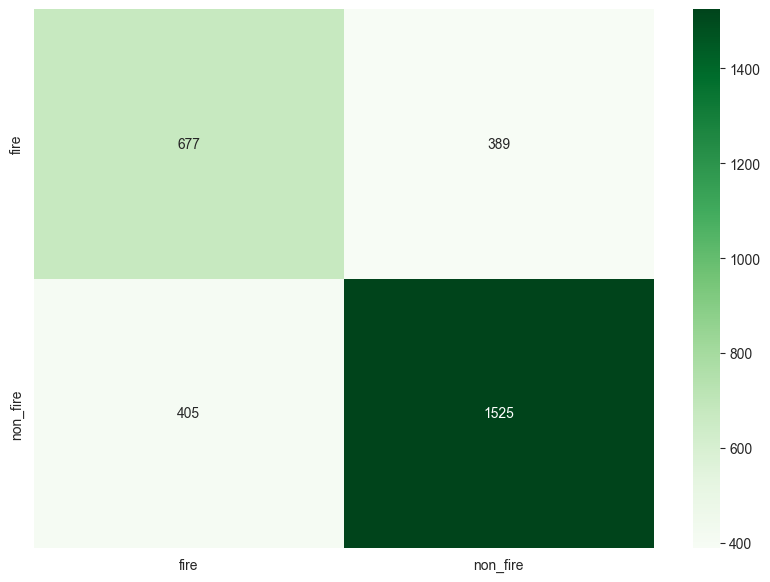

In [206]:
df_cm = pd.DataFrame(first_best_model_cm, index = ['fire', 'non_fire'],
                  columns = ['fire', 'non_fire'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Greens')

In [207]:
precision = precision_score(test_labels, first_best_predictions)
precision

0.7901554404145078

In [208]:
recall = recall_score(test_labels, first_best_predictions)
recall

0.796760710553814

In [209]:
f1 = f1_score(test_labels, first_best_predictions)
f1

0.7934443288241415

In [218]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
def plot_roc(labels, predictions):
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

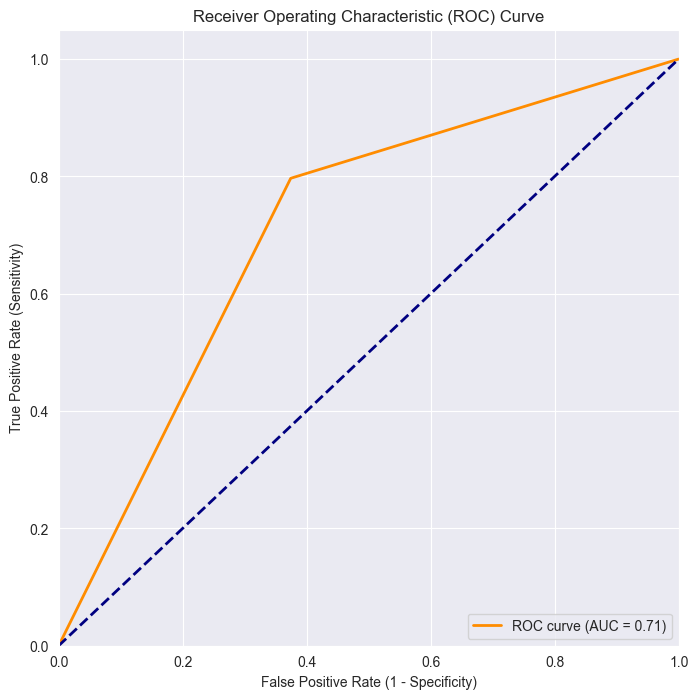

In [219]:
plot_roc(test_labels, first_best_predictions)

In [221]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_pr_curve (labels, predictions):
    # Calculate AUROC
    auroc = roc_auc_score(labels, predictions)
    print(f'AUROC: {auroc:.4f}')

    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(labels, predictions)
    auprc = auc(recall, precision)
    print(f'Area Under the PR Curve (AUPRC): {auprc:.4f}')

    # Plot PR curve
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUPRC = {auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

AUROC: 0.7112
Area Under the PR Curve (AUPRC): 0.8584


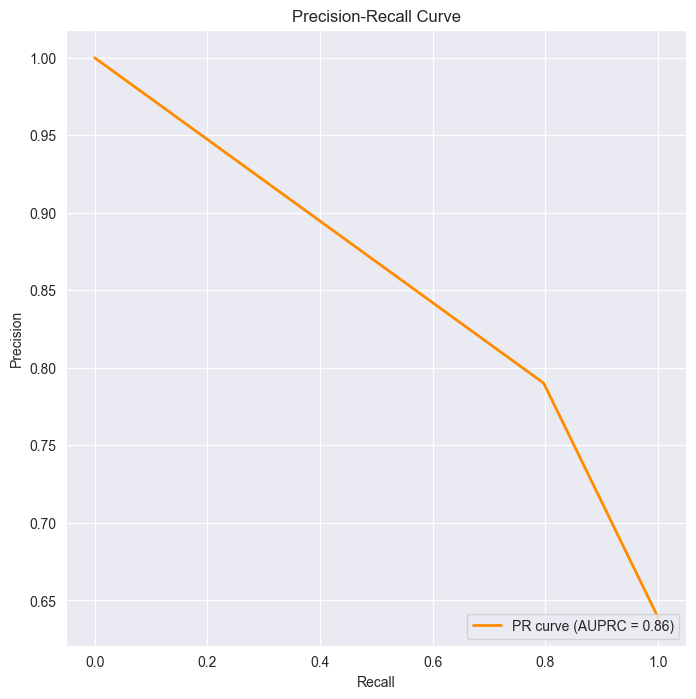

In [222]:
plot_pr_curve(test_labels, first_best_predictions)

In [214]:
full_model_name = "dummy_cnn_full_dataset"
full_model_best = SimpleCNN()
full_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_name, "epoch_24.pt")))

<All keys matched successfully>

In [215]:
full_best_predictions, test_labels = get_confusion_matrix(full_model_best, custom_test_loader)
full_best_model_cm = confusion_matrix(full_best_predictions, test_labels)
full_best_model_cm

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

array([[ 859,  367],
       [ 223, 1547]], dtype=int64)

<Axes: >

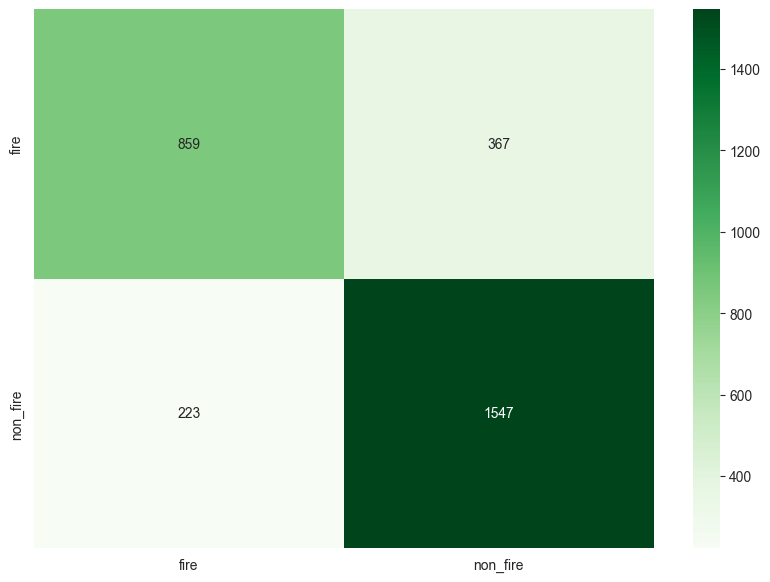

In [216]:
df_cm = pd.DataFrame(full_best_model_cm, index = ['fire', 'non_fire'],
                  columns = ['fire', 'non_fire'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Greens')

In [217]:
precision = precision_score(test_labels, full_best_predictions)
print("Precision: ", precision)
recall = recall_score(test_labels, full_best_predictions)
print('Recall: ', recall)
f1 = f1_score(test_labels, full_best_predictions)
print('F1 Score: ', f1)

Precision:  0.8740112994350282
Recall:  0.8082549634273772
F1 Score:  0.8398479913137894


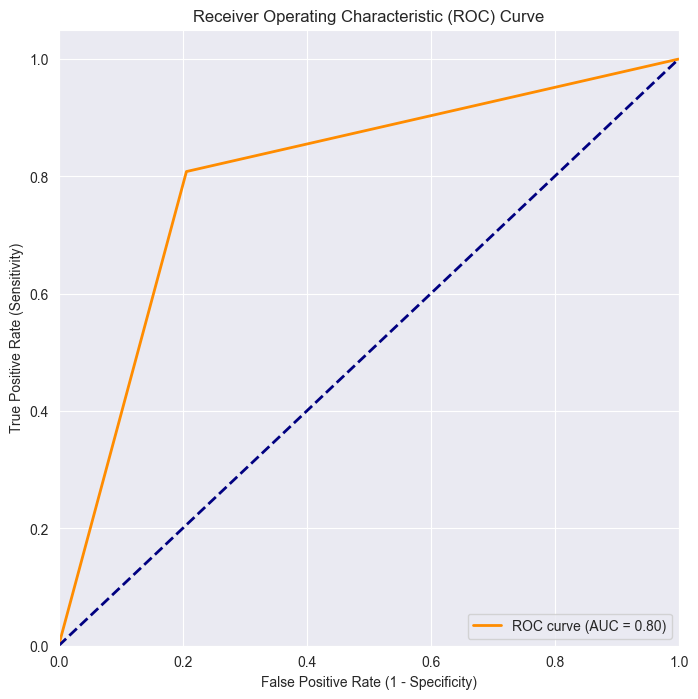

In [220]:
plot_roc(test_labels, full_best_predictions)

AUROC: 0.8011
Area Under the PR Curve (AUPRC): 0.9024


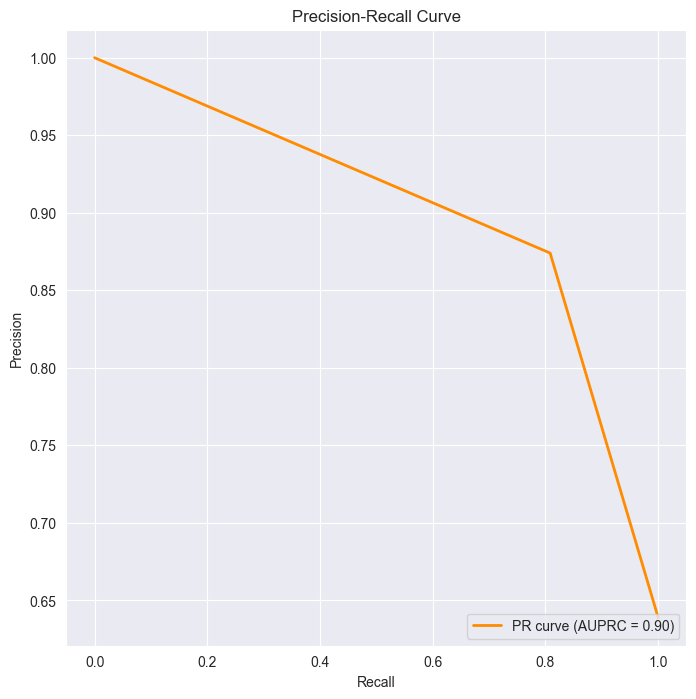

In [223]:
plot_pr_curve(test_labels, full_best_predictions)

In [224]:
full_model_weighted_name = "dummy_cnn_full_dataset_weighted"
full_model_weighted = SimpleCNN()
full_model_weighted.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_weighted_name + ".pt")))

<All keys matched successfully>

In [225]:
full_weighted_predictions, test_labels = get_confusion_matrix(full_model_weighted, custom_test_loader)
full_model_weighted_cm = confusion_matrix(full_weighted_predictions, test_labels)
full_model_weighted_cm

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

array([[ 950,  370],
       [ 132, 1544]], dtype=int64)

<Axes: >

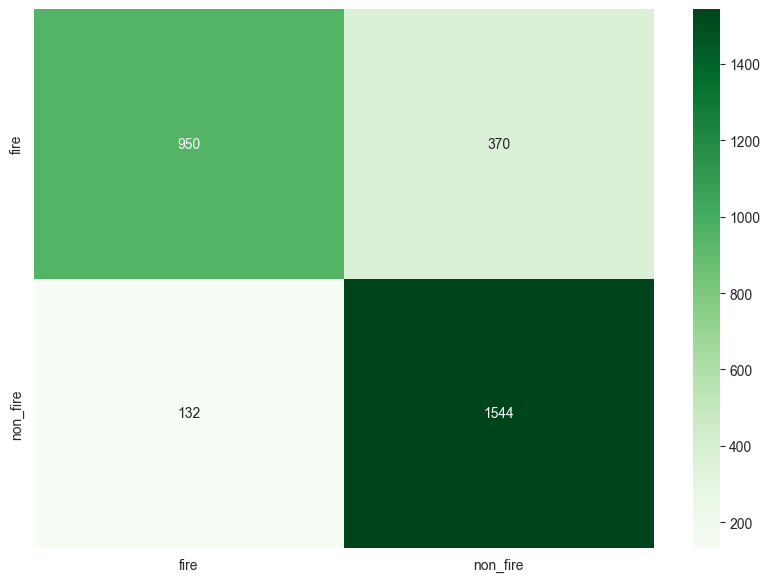

In [226]:
df_cm = pd.DataFrame(full_model_weighted_cm, index = ['fire', 'non_fire'],
                  columns = ['fire', 'non_fire'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Greens')

In [227]:
precision = precision_score(test_labels, full_weighted_predictions)
print("Precision: ", precision, ";")
recall = recall_score(test_labels, full_weighted_predictions)
print('Recall: ', recall, ";")
f1 = f1_score(test_labels, full_weighted_predictions)
print('F1 Score: ', f1)

Precision:  0.9212410501193318 ;
Recall:  0.8066875653082549 ;
F1 Score:  0.86016713091922


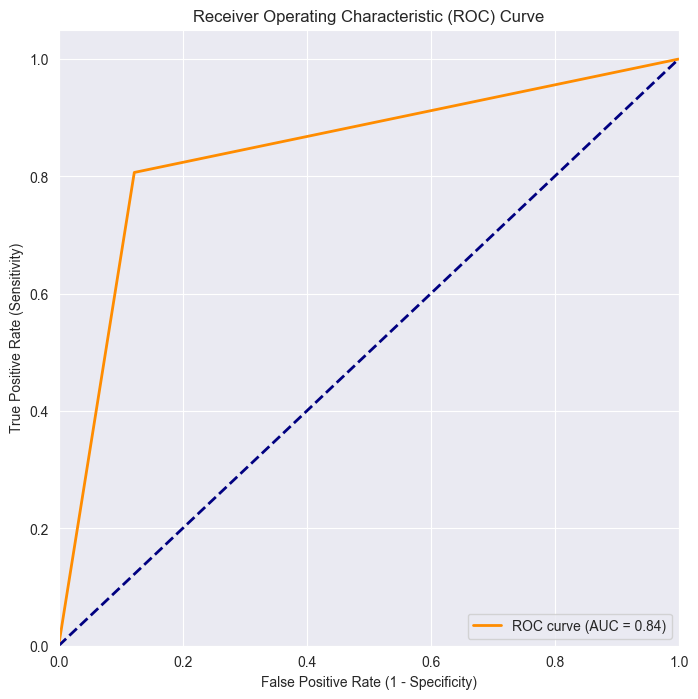

In [228]:
plot_roc(test_labels, full_weighted_predictions)

AUROC: 0.8423
Area Under the PR Curve (AUPRC): 0.9257


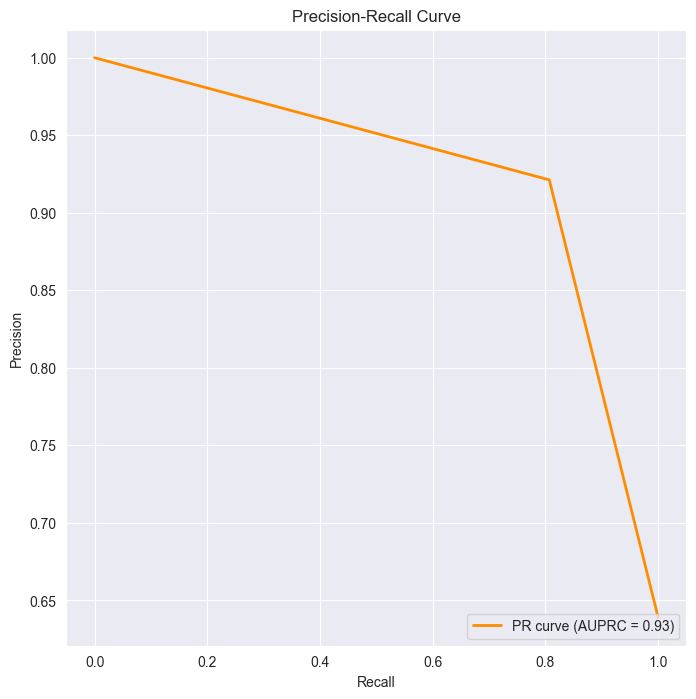

In [229]:
plot_pr_curve(test_labels, full_weighted_predictions)

In [231]:
import cv2

In [233]:
def run_video(filename, model : torch.nn.Module, transforms: transforms):
    """
        Inputs: 
        - filename: the path to the video to run
        - model: the CNN model to make the prediction on each frame of the video
        - transforms: the transform to be applied to each frame of the video in order to make it
          compatible with the model
        Outputs: 
        - Arr[is_fire_percentage, is_not_fire_percentage]
    """

    predictions = [0, 0]
    total_frames = 1

    cap = cv2.VideoCapture(filename)

    while True:
        ret, image = cap.read()

        # Check if the frame was successfully read
        if not ret:
            break
        
        # Make a prediction for the current frame if a model was given
        if model != None and transforms != None:
            draw = image.copy()
            draw = cv2.resize(draw, (640, 480))
            draw = transforms(draw)

            outputs = model(draw)
            #prob = torch.sigmoid(outputs)
            _, prob = torch.max(outputs, 1)

            if prob > 0.5:
                color = (0, 255, 0)
                predictions[1] += 1
            else:
                color = (0, 0, 255)
                predictions[0] += 1
            
            cv2.putText(image, "fire" if prob.item() == 0 else "non_fire", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Display the frame
        cv2.imshow('framename', image)

        total_frames += 1

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return {'fire': predictions[0]/total_frames, 'non_fire': predictions[1]/total_frames}

In [234]:
full_model_weighted = full_model_weighted.to("cpu")

transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])

In [237]:
run_video(os.path.join(base_path, "test dataset videos", "cloud_forming.mp4"), full_model_weighted, transform_video)

{'fire': 0.2519301097114994, 'non_fire': 0.7476635514018691}